In [8]:

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random

import jdgsim
from jdgsim.potentials import NFW
from jdgsim.integrators import leapfrog
from jdgsim.dynamics import direct_acc

# Initialization of the simulaiton

In [10]:
G = 4.498*10**(-6) #kpc³ / (M☉ Gyr²)
N_particles = 2

position = jnp.zeros((N_particles, 3))
velocity = jnp.zeros((N_particles, 3))
mass = jnp.ones((N_particles, ))

In [3]:
position = position.at[0, :].set([1., 0, 0])
position

Array([[1., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [4]:
def construct_initial_state(position, velocity):
    state = jnp.zeros((position.shape[0], 2, position.shape[1]))
    state = state.at[:, 0, :].set(position)
    state = state.at[:, 1, :].set(velocity)
    
    return state 
    

In [5]:
initial_state = construct_initial_state(position=position, velocity=velocity)

In [6]:
initial_state.shape

(2, 2, 3)

# Direct Forces

In [7]:
# tried with half precision
# import jax.numpy as jnp
# import jax
# from jax import jit, vmap

# G = jnp.float16(6.67430e-11)  # Gravitational constant in float16

# @jit
# def compute_force(particle_i, particle_j, mass_i, mass_j, softening):
#     """Compute gravitational force exerted on particle_i by particle_j (float16)."""
#     r_ij = jnp.array(particle_i[0, :] - particle_j[0, :], dtype=jnp.float16)
#     r2 = jnp.dot(r_ij, r_ij) + jnp.float16(softening**2)  # Avoid singularities
#     inv_r3 = jnp.where(r2 > 0, jnp.float16(1.0) / jnp.sqrt(r2**3), jnp.float16(0.0))  # Stable inverse
#     return G * jnp.float16(mass_i * mass_j) * inv_r3 * r_ij  # Vectorized force calculation

# @jit
# def compute_all_forces(state, masses, softening=jnp.float16(1e-10)):
#     """Compute net force acting on each body in float16 precision."""
#     state = state.astype(jnp.float16)
#     masses = masses.astype(jnp.float16)

#     def force_on_body(particle_i, mass_i):
#         """Compute net force on a single body by summing over all others."""
#         forces = vmap(compute_force, in_axes=(None, 0, None, 0, None))(particle_i, state, mass_i, masses, softening)
#         return jnp.sum(forces, axis=0, dtype=jnp.float16)  # Sum all forces

#     return vmap(force_on_body, in_axes=(0, 0))(state, masses)

# forces = compute_all_forces(initial_state, mass, )

In [8]:
def compute_acc(particle_i, particle_j, mass_i, mass_j, softening) -> jnp.ndarray:
    """Compute gravitational force exerted on body1 by body2."""
    r_ij = particle_i[0, :] - particle_j[0, :]
    r_mag = jnp.linalg.norm(r_ij) + softening  # Avoid division by zero and close encounter with softening
    acc_ij = G  * mass_j / r_mag**2
    return - (acc_ij / r_mag) * r_ij

@jit
def compute_all_acc(state, mass, softening=1e-10):
    """Compute net force acting on each body using JAX's vmap."""
    def net_force_on_body(particle_i, mass_i):
        acc = vmap(lambda particle_j, mass_j: compute_acc(particle_i, particle_j, mass_i, mass_j, softening))(state, mass)
        return jnp.sum(acc, axis=0)  # Sum all forces acting on the body

    return vmap(net_force_on_body)(state, mass)

acc = compute_all_acc(initial_state, mass, )

In [9]:
acc

Array([[-6.6743e-11,  0.0000e+00,  0.0000e+00],
       [ 6.6743e-11,  0.0000e+00,  0.0000e+00]], dtype=float32)

In [10]:
# #highly memory inefficient, 149.01GiB for 100_000 stars
# @jit
# def acceleration_vectorized(initial_state, mass, softening: float = 0):
    
#     N_particles = len(initial_state[:, 0])
#     #distance matrix
#     x_ij = initial_state[:, 0, 0].reshape((N_particles, 1)) - initial_state[:, 0, 0]
#     y_ij = initial_state[:, 0, 1].reshape((N_particles, 1)) - initial_state[:, 0, 1]
#     z_ij = initial_state[:, 0, 2].reshape((N_particles, 1)) - initial_state[:, 0, 2] 

#     #distance matrix
#     r_ij = jnp.concatenate((x_ij, y_ij, z_ij)).reshape((3, N_particles, N_particles))
#     #vector of 
#     r = jnp.sqrt(x_ij**2 + y_ij**2 + z_ij**2) + softening
#     print(r.shape)
#     print(r_ij.shape)
#     #acceleration caused by the j-th particle on the i-th particle
#     a = (-r_ij/r**3 @ mass).T 
#     acceleration = jnp.sum(a, axis=1)
    
#     return acceleration 

In [11]:
# #very slow  but memory efficient
# @jit
# def compute_force(particle_i, particle_j, mass_i, mass_j, softening):
#     """Compute gravitational force exerted on particle_i by particle_j."""
#     r_ij = particle_i[0, :] - particle_j[0, :]
#     r2 = jnp.dot(r_ij, r_ij) + softening**2  # Softening avoids singularity
    
#     return G * mass_i * mass_j * (1/r2)**2 * r_ij  # Vectorized force calculation

# @jit
# def compute_all_forces(state, mass, softening=1e-10):
#     """Compute net force acting on each body in a memory-efficient way."""
#     N = state.shape[0]

#     def body_force(i, total_force):
#         """Compute net force acting on body i by summing over all other bodies."""
#         particle_i, mass_i = state[i], mass[i]

#         def force_contribution(j, acc_force):
#             """Compute contribution of body j to body i's force and accumulate."""
#             return acc_force + compute_force(particle_i, state[j], mass_i, mass[j], softening)

#         force_i = jax.lax.fori_loop(0, N, force_contribution, jnp.zeros(3))
#         return total_force.at[i].set(force_i)

#     # Accumulate forces using a loop (O(N²) complexity, but O(N) memory)
#     total_forces = jnp.zeros((N, 3))
#     total_forces = jax.lax.fori_loop(0, N, body_force, total_forces)

#     return total_forces

# forces = compute_all_forces(initial_state, mass, )

# Integrators

In [12]:
@partial(jax.jit, static_argnames=['tstep', 'acceleration_estimator', 'external_accelerations', 'softening', 'args'])
def integrator_leapfrog(state,
                        mass,
                        tstep: float,
                        acceleration_estimator: Union[Callable,List],
                        softening: float = 0.,
                        external_accelerations: Optional[List] = None,
                        args: Optional[dict] = None):
    """
    Simple implementation of a symplectic Leapfrog (Verlet) integrator for N-body simulations.
    :param particles: Instance of the class :class:`~fireworks.particles.Particles`
    :param tstep: Times-step for current integration (notice some methods can use smaller sub-time step to
    achieve the final result
    :param acceleration_estimator: It needs to be a function from the module (:mod:`fireworks.nbodylib.dynamics`)
    following the input/output style of the template function  (:func:`fireworks.nbodylib.dynamics.acceleration_estimate_template`).
    :param softening: softening parameter for the acceleration estimate, can use 0 as default value
    :param external_accelerations: a list of additional force estimators (e.g. an external potential field) to
    consider to estimate the final acceleration (and if available jerk) on the particles
    :return: A tuple with 5 elements:

        - The updated particles instance
        - tstep, the effective timestep evolved in the simulation (for some integrator this can be
            different wrt the input tstep)
        - acc, Nx3 numpy array storing the final acceleration for each particle, ca be set to None
        - jerk, Nx3 numpy array storing the time derivative of the acceleration, can be set to None
        - pot, Nx1 numpy array storing the potential at each particle position, can be set to None

    """
    if args is not None:
        acc = acceleration_estimator(state, mass, softening, **args)
    else:
        acc = acceleration_estimator(state, mass, softening)

    # Check additional accelerations
    if external_accelerations is not None:
        for ext_acc_estimator in external_accelerations:
            acct = ext_acc_estimator(state, mass, softening)
            acc += acct
            
    # removing half-step velocity
    state = state.at[:, 0].set(state[:, 0] + state[:, 1]*tstep + 0.5*acc*(tstep**2))

    if args is not None:
        acc2 = acceleration_estimator(state, mass, softening, **args)
    else:
        acc2 = acceleration_estimator(state, mass, softening)

    #Check additional accelerations
    if external_accelerations is not None:
        for ext_acc_estimator in external_accelerations:
            acct = ext_acc_estimator(state, mass, softening)
            acc2 += acct

    state = state.at[:, 1].set(state[:, 1] + 0.5*(acc + acc2)*tstep)
    
    return (state, tstep)


In [13]:
future_state, tstep = integrator_leapfrog(initial_state, mass, tstep=0.1, acceleration_estimator=compute_all_acc, softening=1e-10)

In [14]:
initial_state.shape

(2, 2, 3)

In [15]:
time = 1000
tstep = 0.1
n_tstep = int(time/tstep)

def update_state(_, state):
    return integrator_leapfrog(state, mass, tstep, compute_all_acc, softening=1e-10)[0]

# use lax fori_loop to unroll the loop
update_state = jax.lax.fori_loop(0, n_tstep, update_state, initial_state)

In [16]:
update_state

Array([[[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-6.6745272e-08,  0.0000000e+00,  0.0000000e+00]],

       [[ 3.3371034e-05,  0.0000000e+00,  0.0000000e+00],
        [ 6.6745272e-08,  0.0000000e+00,  0.0000000e+00]]], dtype=float32)

# External potential

# simple example

In [17]:
import jax
import jax.numpy as jnp
from jax import random

def sample_plummer_sphere(key, n_particles, mass=1.0):
    """
    Generate particle samples from a Plummer sphere distribution using JAX.
    
    :param key: JAX random key.
    :param n_particles: Number of particles to generate.
    :param mass: Total mass of the Plummer sphere.
    :return: A tuple (positions, velocities) where positions and velocities are Nx3 JAX arrays.
    """
    G = 1.0  # Gravitational constant in appropriate units

    # Generate positions
    def generate_position(key):
        while True:
            key, subkey = random.split(key)
            x1, x2, x3 = random.uniform(subkey, (3,), minval=-1, maxval=1)
            r2 = x1**2 + x2**2 + x3**2
            if r2 < 1:
                break
        r = (r2**(-2/3) - 1)**(-0.5)
        return r * jnp.array([x1, x2, x3]), key

    positions = []
    for _ in range(n_particles):
        pos, key = generate_position(key)
        positions.append(pos)
    positions = jnp.array(positions)

    # Generate velocities
    def generate_velocity(key, position):
        while True:
            key, subkey = random.split(key)
            x1, x2, x3 = random.uniform(subkey, (3,), minval=-1, maxval=1)
            v2 = x1**2 + x2**2 + x3**2
            if v2 < 1:
                break
        v = jnp.sqrt(2 * G * mass / (1 + jnp.sum(position**2))**0.5)
        return v * jnp.array([x1, x2, x3]), key

    velocities = []
    for pos in positions:
        vel, key = generate_velocity(key, pos)
        velocities.append(vel)
    velocities = jnp.array(velocities)
    
    mass = jnp.ones(n_particles)
    return positions, velocities, mass

# Example usage
key = random.PRNGKey(0)
n_particles = 1000
positions, velocities, mass = sample_plummer_sphere(key, n_particles)

print("Positions:", positions)
print("Velocities:", velocities)

Positions: [[-0.08266522  0.20783293  1.1944786 ]
 [ 0.17643213  0.01555626 -0.05219955]
 [-0.15863852 -0.03069348  0.4375243 ]
 ...
 [-7.1809897   1.7427928  -1.5158179 ]
 [-0.4651966   0.63366556  0.54709274]
 [ 2.4286952  -1.4300728   1.1401299 ]]
Velocities: [[ 0.45562506  0.70586276  0.3467178 ]
 [-0.7937889  -0.10286368  0.9734987 ]
 [ 0.15850301 -0.76914155 -0.09509051]
 ...
 [ 0.19509506 -0.2171825  -0.0429808 ]
 [ 0.34860754  0.2773026   0.98933583]
 [-0.29516575 -0.04459352  0.5764605 ]]


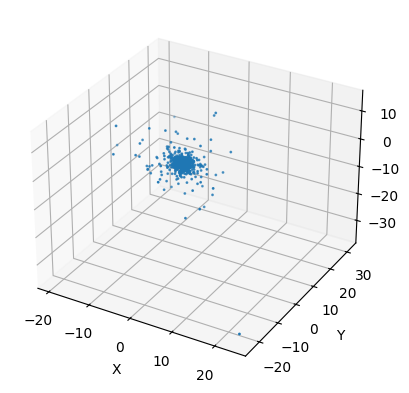

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [19]:
initial_state = construct_initial_state(position=positions, velocity=velocities)


In [28]:
time = 50
tstep = 0.1
n_tstep = int(time/tstep)

def update_state(_, state):
    return integrator_leapfrog(state, mass, tstep, compute_all_acc, softening=1e-10)[0]

# use lax fori_loop to unroll the loop
update_state = jax.lax.fori_loop(0, n_tstep, update_state, initial_state)

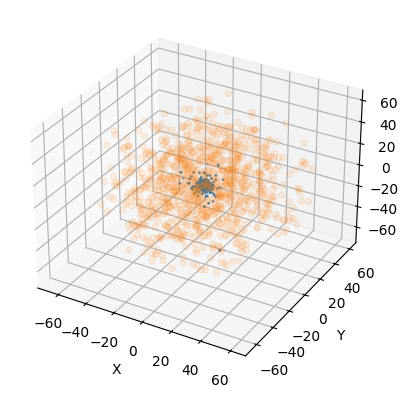

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=1)
ax.scatter(update_state[:, 0, 0], update_state[:, 0, 1], update_state[:, 0, 2], alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()